In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
from scipy.stats import ttest_ind, pearsonr, gamma, normaltest

sns.set_context("paper", font_scale=2)

# Содержание

Данный ноутбук содержит домашние задания на первые четыре дня интенсива "Погружение в A/B-тестирование".

Для каждого дня и темы вам предоставлен код из соответствующей демонстрации. Для выполнения задания вам нужно произвести соответствующие изменения в существующем коде, чтобы он подходил под условия задания. Некоторые из мест, которые нужно изменить, вы можете найти по комментарию **#TODO**. Остальные места для изменения кода вам нужно найти самостоятельно.

Вопросы в рамках одной темы нужно выполнять последовательно, т.к. результаты последующих заданий зависят от расчетов предыдущих заданий.

## Практическое задание 1 "Расчет p-value через bootstrap-тест"

Возьмите в качестве increment число 10. 

1. Как вы считаете, нужно увеличить или уменьшить количество элементов в выборке относительно исходного, чтобы задетектировать эту разницу? 
2. Подберите количество элементов в выборке, при котором Bootstrap-тест будет показывать стат.значимую разницу между выборками? Число округлите вверх до сотен.

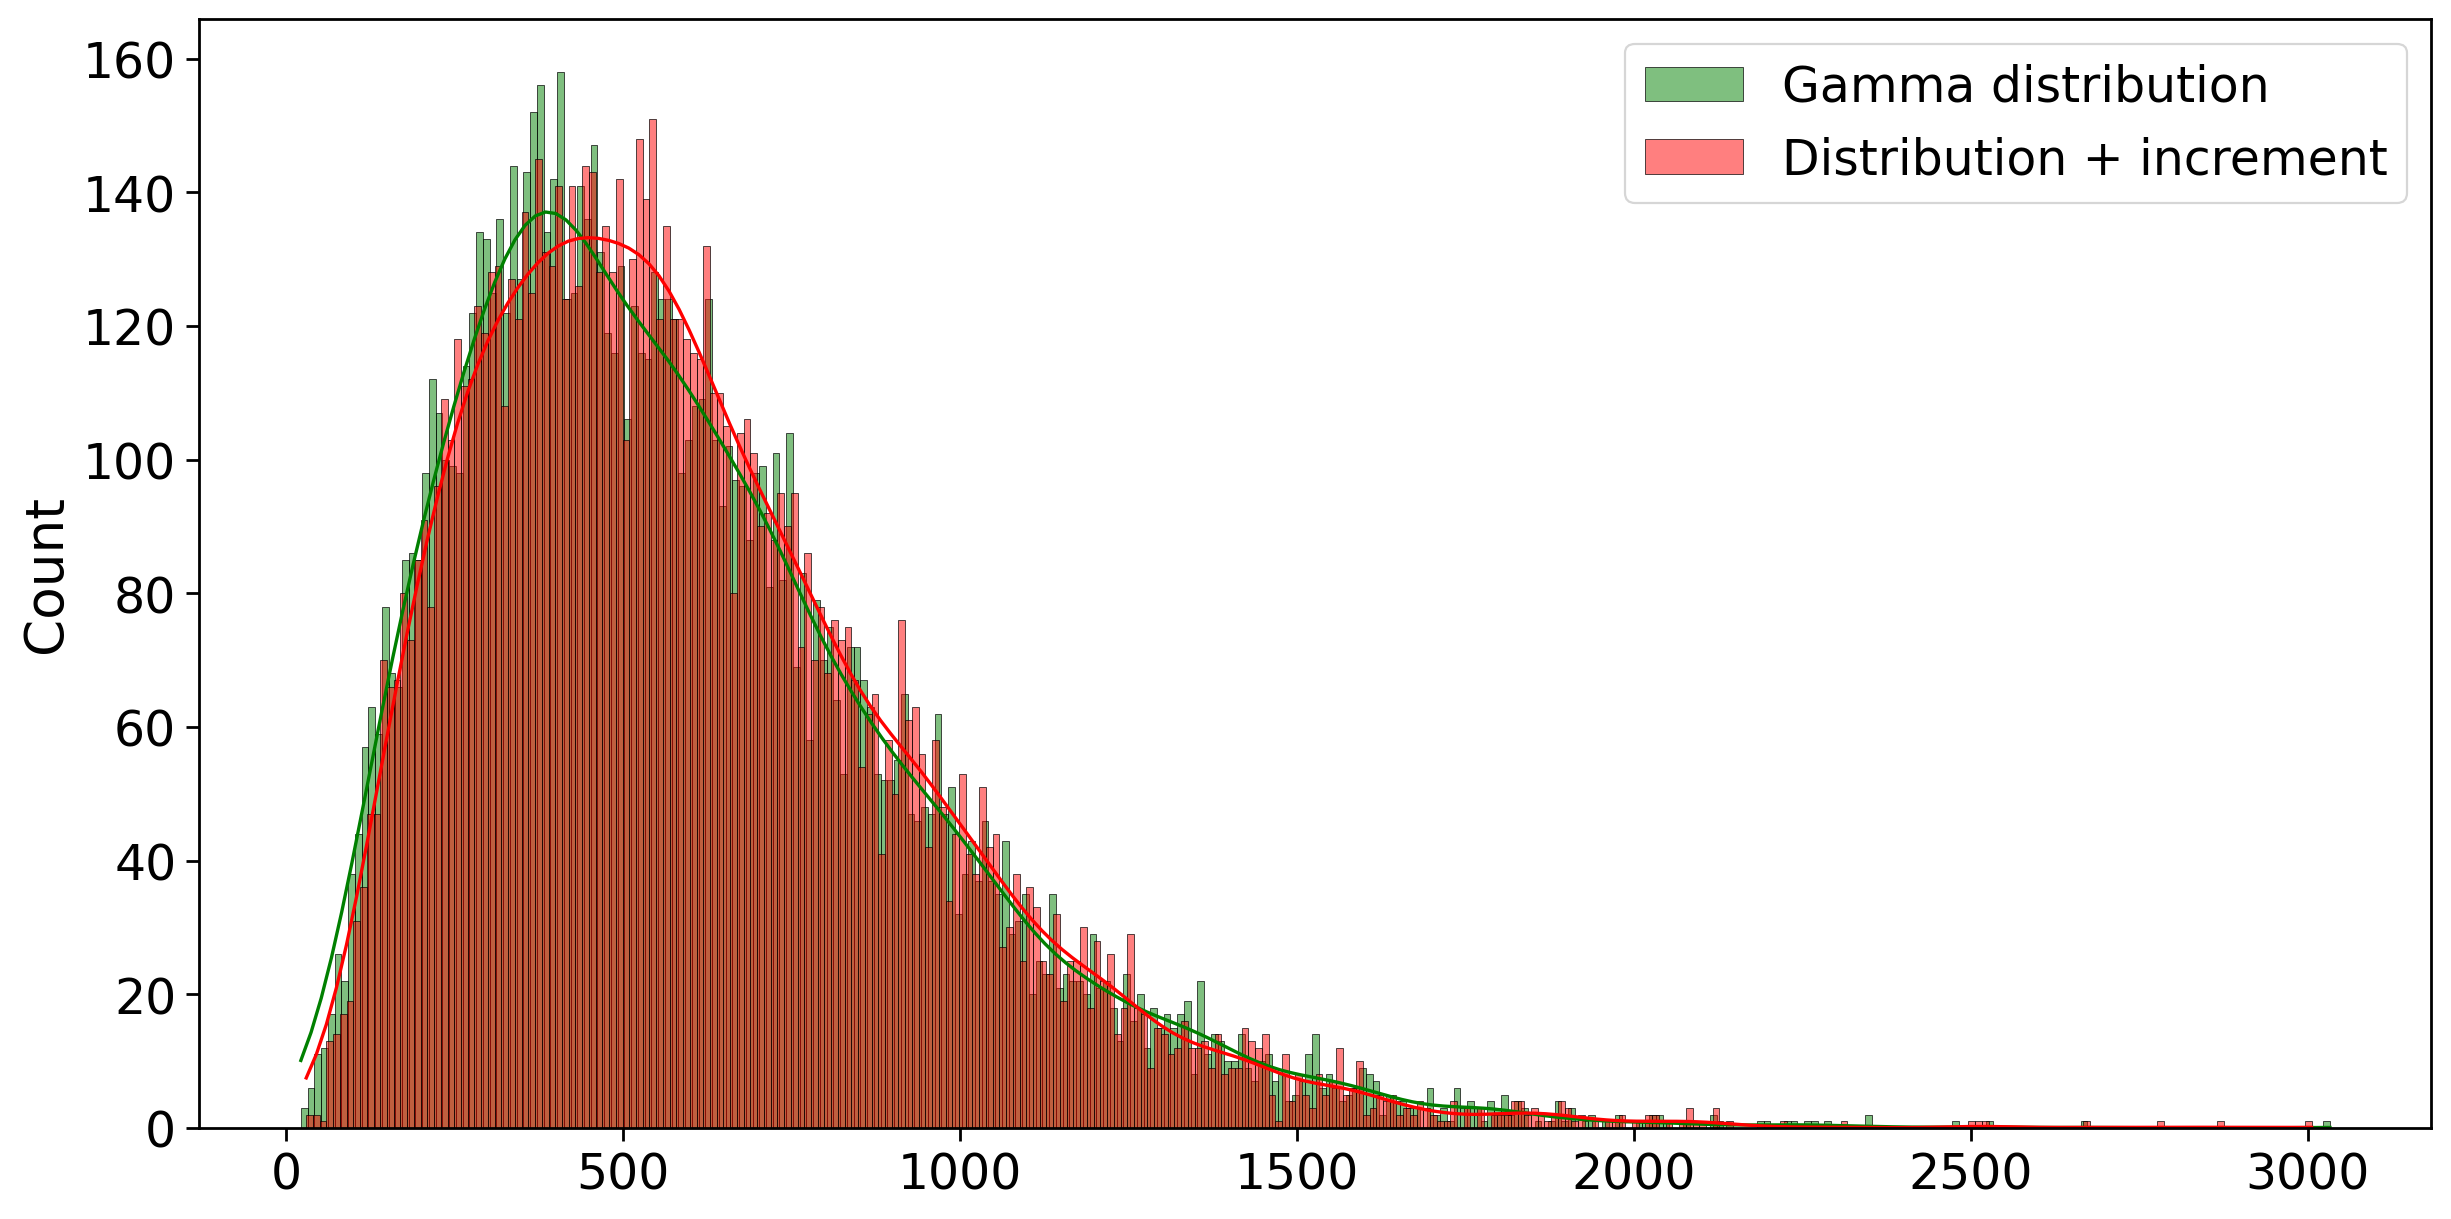

In [20]:
# Генерируем 2 гамма распределения.
# Берем для них одинаковые параметры, но ко второму добавляем инкремент который можно задать переменной increment
np.random.seed(111)

increment =    20 # TODO: поменяйте инкремент на нужный
gamma_distr_1 = np.random.gamma(3, 1, 10000) * 200              # TODO: подберите нужное количество элементов в выборке
gamma_distr_2 = np.random.gamma(3, 1, 10000) * 200 + increment  # TODO: подберите нужное количество элементов в выборке

# Отображаем гистограмму распределений и кривые плотности вероятности
fig, ax = plt.subplots(figsize=(14.4, 7.2), dpi=200)

sns.histplot(gamma_distr_1, kde=True, binwidth=10, ax=ax, color='green', alpha=0.5, label='Gamma distribution')
sns.histplot(gamma_distr_2, kde=True, binwidth=10, ax=ax, color='red', alpha=0.5, label='Distribution + increment')

ax.legend();

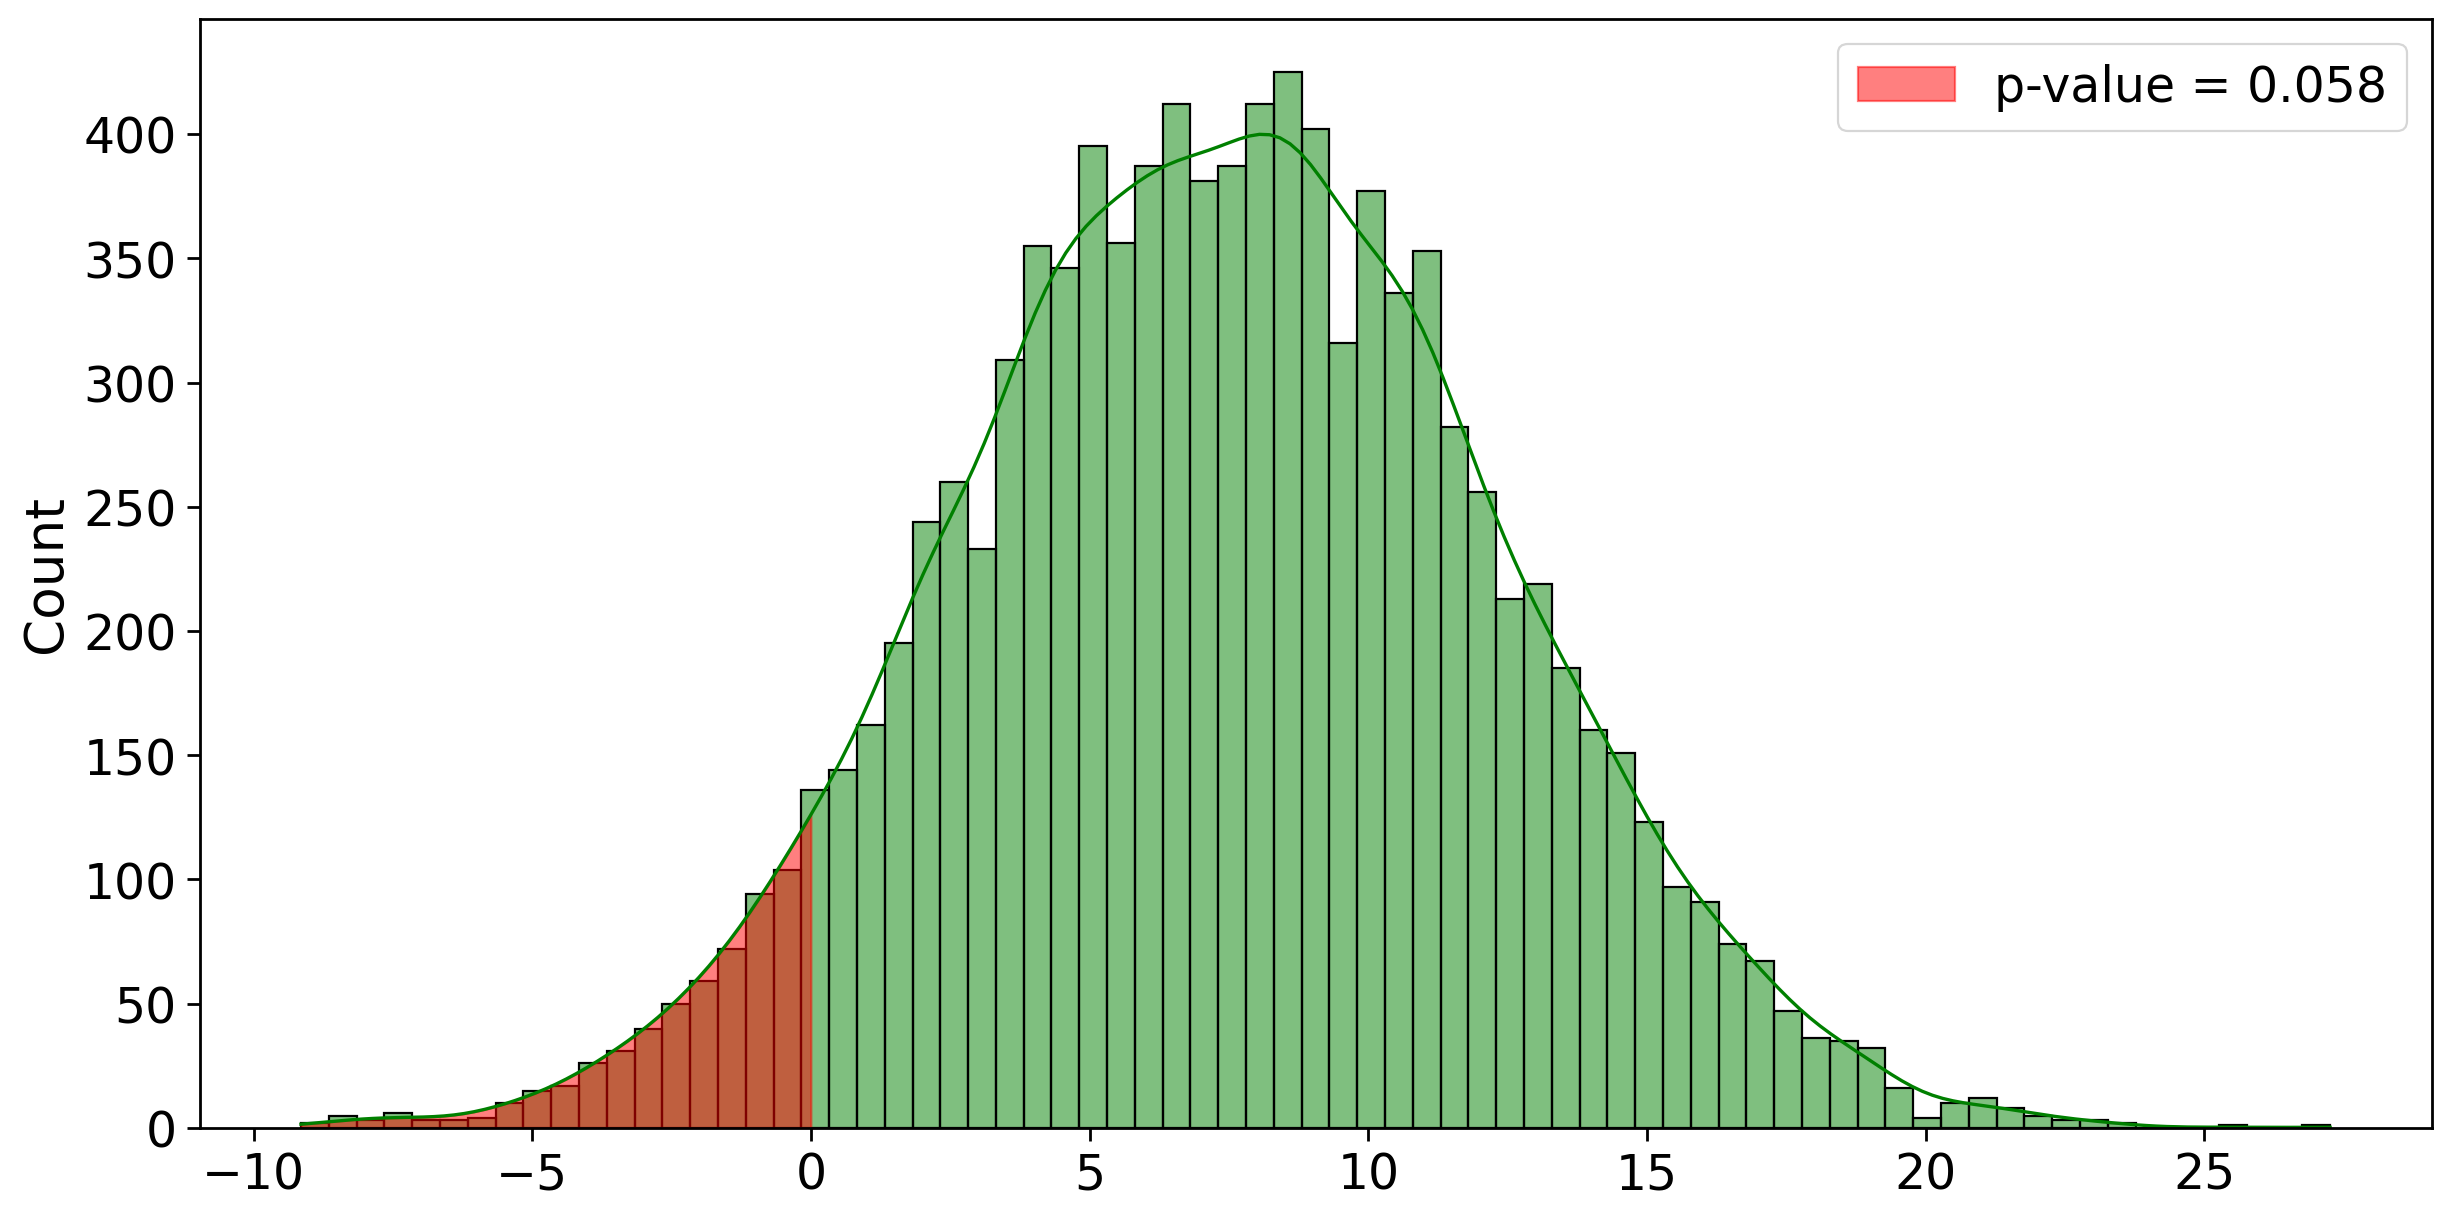

In [86]:
# С помощью bootstrap берем подвыборки с возвратом из распределений.
# Для полученных подвыборок считаем среднее и затем разность этих средних запоминаем
np.random.seed(111)

diff_list = []
for _ in range(10000):
    sample1 = np.random.choice(gamma_distr_1, 10000)
    sample2 = np.random.choice(gamma_distr_2, 10000)
    diff_list.append(np.mean(sample2) - np.mean(sample1))

# Отображаем гистограмму полученных разностей
fig, ax = plt.subplots(figsize=(14.4, 7.2), dpi=200)

sns.histplot(diff_list, binwidth=0.5, kde=True, ax=ax, color='green', alpha=0.5)

# Рассчитываем p-value как количество полученных разностей меньше 0 к общему количеству полученных разностей
p_value = len([i for i in diff_list if i <= 0]) / len(diff_list)

# Закрашиваем область слева от 0
kde_xdata, kde_ydata= ax.lines[0].get_data()
ax.fill_between(kde_xdata, kde_ydata, where=(kde_xdata<0), color='red', alpha=0.5, label=f'p-value = {p_value:.3f}')

ax.legend();

In [139]:
# Создаем функцию, которая будет проводить bootstrap-тест
def bootstrap_test(distr_1, distr_2, sample_size, n_bootstraps=1000):
    """ 
    Функция выполняет Bootstrap-тест для проверки разницы между двумя выборками и возвращает p-value.
    
        distr_1:         Первая выборка. 
        distr_2:         Вторая выборка. 
        sample_size:     Размер подвыборки. 
        n_bootstraps:    Количество итераций бутстрапинга. 
        p_value:         Вероятность того, что среднее второй выборки больше среднего первой. 
        
    """
    mean_diffs = []
    np.random.seed(111)
    for _ in range(n_bootstraps):
        
        sample_1 = np.random.choice(distr_1, size=sample_size, replace=True)
        sample_2 = np.random.choice(distr_2, size=sample_size, replace=True)
        
        # Рассчитываем средние значения
        mean_1 = np.mean(sample_1)
        mean_2 = np.mean(sample_2)
        
        # Сохраняем разницу средних
        mean_diffs.append(mean_2 - mean_1)
    
    # Находим p-value
    p_value = sum(np.array(mean_diffs) > 0) / len(mean_diffs)
    
    return p_value

# Тестируем разные размеры выборок
alpha = 0.058
for size in range(9000, 15000, 100):
    
    np.random.seed(111)
    increment =    10
    gamma_distr_1 = np.random.gamma(3, 1, size) * 200             
    gamma_distr_2 = np.random.gamma(3, 1, size) * 200 + increment
    
    p_val = bootstrap_test(gamma_distr_1, gamma_distr_2, size)
    if p_val > 1-alpha:
        print(f'''Чтобы заметить разницу между смещением (increment), относительно исходного (20), нужно увеличить количество элементов в выборке.
Размер выборки при котором bootstrap-тест будет показывать стат. значимую разницу между выборками: {size}''')
        break

 Чтобы заметить разницу между смещением (increment), относительно исходного (20), нужно увеличить количество элементов в выборке.
Размер выборки при котором bootstrap-тест будет показывать стат. значимую разницу между выборками: 12400


## Практическое задание 2 "Доверительный интервал и количество наблюдений"

1. Возьмите гамма-распределение (параметры: k=2, theta = 2).
2. Возьмите две подвыборки со следующими размерами: 200 и 100 000.
3. Оцените ширину доверительного интервала для среднего каждой из двух подвыборок. Округлите ширину обоих доверительных интервалов до 6-го знака после запятой.
4. Рассчитайте, во сколько раз уменьшится ширина доверительного интервала для второй выборки и округлите значение до целого числа.

MOE1 = 0.20511
MOE2 = 0.019593
-0.017 0.394
0.196 0.235
width_ci1: 0.4110
width_ci2: 0.0390
Z = 1.959963984540054
Sample size = 100, stdev = 1.0465009913699928, E1=0.20511, confint_width = 0.41
Sample size = 10000, stdev = 0.9996687430690615, E1=0.019593, confint_width = 0.039


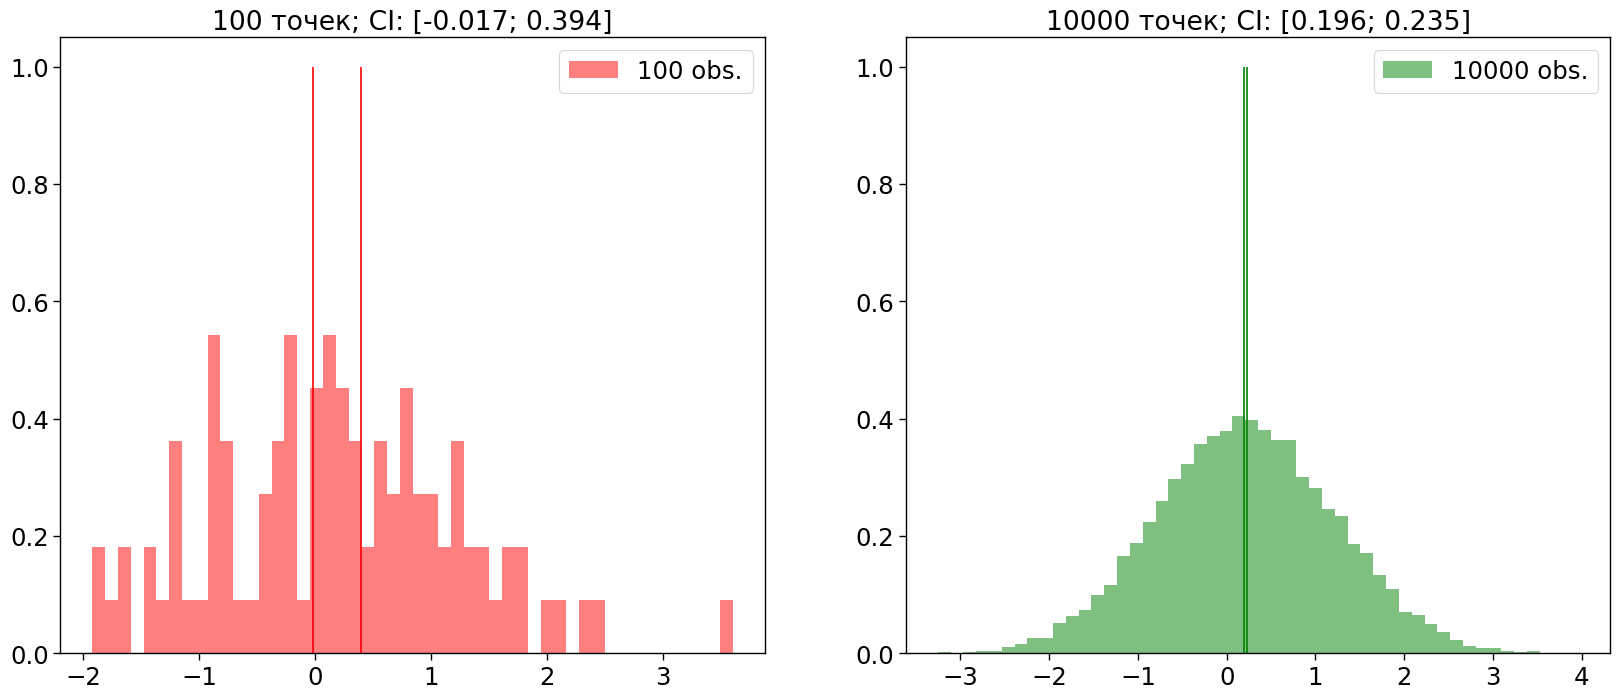

CPU times: user 297 ms, sys: 785 μs, total: 298 ms
Wall time: 295 ms


In [105]:
%%time

np.random.seed(42)

plt.rcParams.update({'font.size': 18})

size = 100_000
a = np.random.normal(0.2, 1, size)            # TODO: создайте гамма-распределение по определению из п.1

size1 = 100                                   # TODO: укажите нужный размер подвыборки №1
size2 = 10_000                                # TODO: укажите нужный размер подвыборки №2
z = abs(norm.ppf(0.975))


# sample 1 from unknown distribution
a1 = np.random.choice(a, size=size1, replace=False)
mean1 = np.mean(a1)
std1 = np.std(a1)

# sample 2 from unknown distribution
a2 = np.random.choice(a, size=size2, replace=False)
mean2 = np.mean(a2)
std2 = np.std(a2)

# margin of error
MOE1 = np.round(z * std1 / np.sqrt(size1), 6)
MOE2 = np.round(z * std2 / np.sqrt(size2), 6)

print(f'MOE1 = {MOE1}')
print(f'MOE2 = {MOE2}')

ci_left1, ci_right1 = round(mean1 - MOE1, 3), round(mean1 + MOE1, 3)
ci_left2, ci_right2 = round(mean2 - MOE2, 3), round(mean2 + MOE2, 3)

# уже по ширине и границам доверительных интервалов можем увидеть, что меньшая выборка склонна не отвергать нулевую гипотезу,
# т.к. содержит 0 в доверительном интервале
print(ci_left1, ci_right1)
print(ci_left2, ci_right2)

# Ширина доверительных интервалов
width_ci1 = ci_right1 - ci_left1
width_ci2 = ci_right2 - ci_left2
# Вывод результатов
print(f'width_ci1: {width_ci1:.4f}')
print(f'width_ci2: {width_ci2:.4f}')

print(f'Z = {z}')
print(f'Sample size = {size1}, stdev = {std1}, E1={MOE1}, confint_width = {np.round(2 * MOE1, 3)}')
print(f'Sample size = {size2}, stdev = {std2}, E1={MOE2}, confint_width = {np.round(2 * MOE2, 3)}')

density = True
lim = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.hist(a1, alpha=0.5, bins=50, color='Red', label=f'{size1} obs.', density=density)
ax1.vlines([ci_left1, ci_right1], 0, 1, color='Red')
ax1.set_title(f'{size1} точек; CI: [{ci_left1}; {ci_right1}]')

ax2.hist(a2, alpha=0.5, bins=50, color='Green', label=f'{size2} obs.', density=density)
ax2.vlines([ci_left2, ci_right2], 0, 1, color='Green')
ax2.set_title(f'{size2} точек; CI: [{ci_left2}; {ci_right2}]')

ax1.legend()
ax2.legend()
plt.show()

MOE1 = 0.331692
MOE2 = 0.017549
3.665 4.328
3.989 4.024
width_ci1: 0.663000
width_ci2: 0.035000
Ширина доверительного интервала для второй выборки уменьшилась в ~19 раз.

Величина доверительного интервала для первой выборки (200) значительно шире, чем для второй выборки (100_000). 
Это отражает тот факт, что большая выборка обеспечивает более точную (примерно в 19 раз) оценку среднего значения, 
тогда как маленькая выборка характеризуется большей неопределенностью.

Z = 1.959963984540054
Sample size = 200, stdev = 2.393323061873812, E1=0.331692, confint_width = 0.663
Sample size = 100000, stdev = 2.8314705532261084, E1=0.017549, confint_width = 0.035


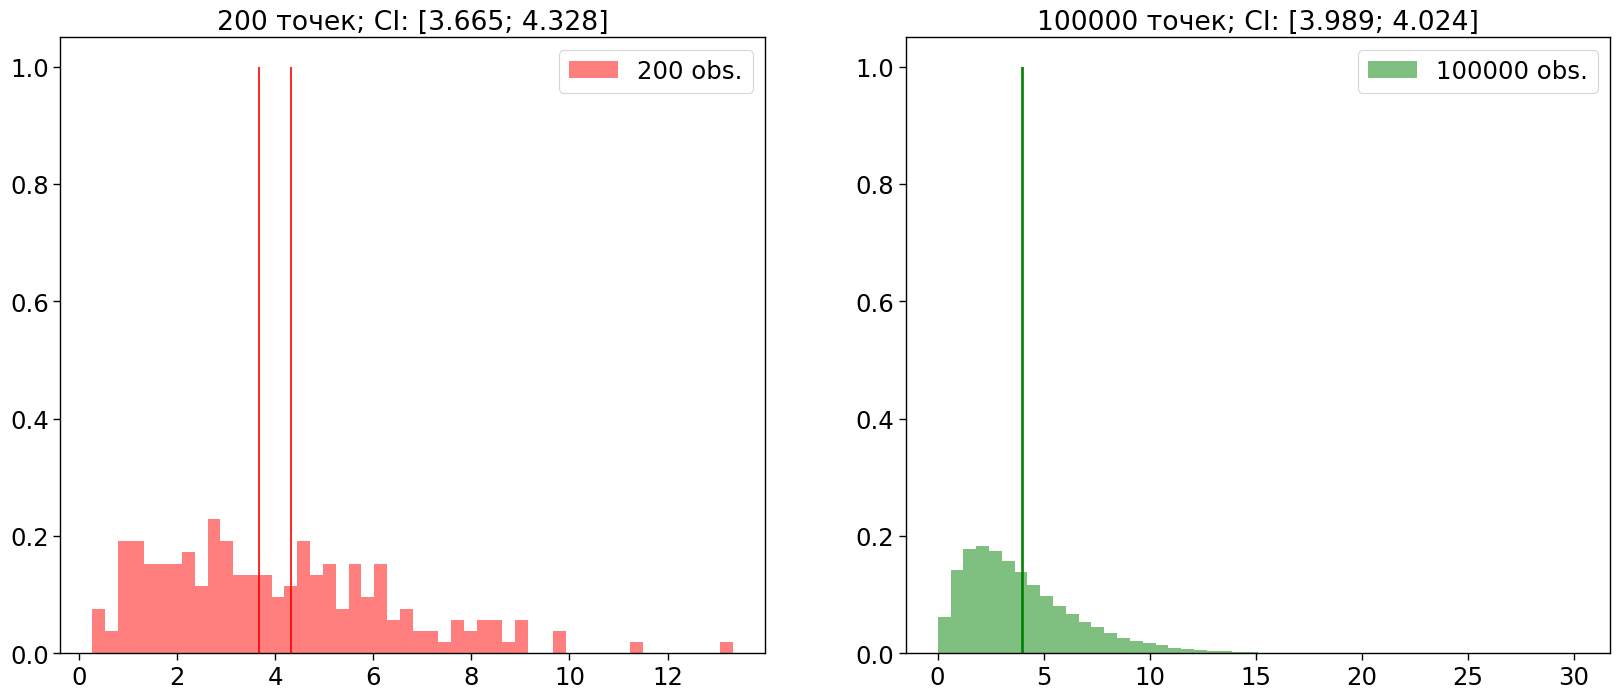

CPU times: user 304 ms, sys: 799 μs, total: 305 ms
Wall time: 301 ms


In [111]:
%%time

np.random.seed(42)

plt.rcParams.update({'font.size': 18})

size = 100_000
a = np.random.gamma(2, 2, size)            # TODO: создайте гамма-распределение по определению из п.1

size1 = 200                                   # TODO: укажите нужный размер подвыборки №1
size2 = 100_000                                # TODO: укажите нужный размер подвыборки №2
z = abs(norm.ppf(0.975))


# sample 1 from unknown distribution
a1 = np.random.choice(a, size=size1, replace=False)
mean1 = np.mean(a1)
std1 = np.std(a1)

# sample 2 from unknown distribution
a2 = np.random.choice(a, size=size2, replace=False)
mean2 = np.mean(a2)
std2 = np.std(a2)

# margin of error
MOE1 = np.round(z * std1 / np.sqrt(size1), 6)
MOE2 = np.round(z * std2 / np.sqrt(size2), 6)

print(f'MOE1 = {MOE1}')
print(f'MOE2 = {MOE2}')

ci_left1, ci_right1 = round(mean1 - MOE1, 3), round(mean1 + MOE1, 3)
ci_left2, ci_right2 = round(mean2 - MOE2, 3), round(mean2 + MOE2, 3)

print(ci_left1, ci_right1)
print(ci_left2, ci_right2)

# Ширина доверительных интервалов
width_ci1 = ci_right1 - ci_left1
width_ci2 = ci_right2 - ci_left2
# Вывод результатов
print(f'width_ci1: {width_ci1:.6f}')
print(f'width_ci2: {width_ci2:.6f}')
print(f'Ширина доверительного интервала для второй выборки уменьшилась в ~{round(width_ci1/width_ci2)} раз.')
print(f'''
Величина доверительного интервала для первой выборки (200) значительно шире, чем для второй выборки (100_000). 
Это отражает тот факт, что большая выборка обеспечивает более точную (примерно в 19 раз) оценку среднего значения, 
тогда как маленькая выборка характеризуется большей неопределенностью.
''')

print(f'Z = {z}')
print(f'Sample size = {size1}, stdev = {std1}, E1={MOE1}, confint_width = {np.round(2 * MOE1, 3)}')
print(f'Sample size = {size2}, stdev = {std2}, E1={MOE2}, confint_width = {np.round(2 * MOE2, 3)}')

density = True
lim = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.hist(a1, alpha=0.5, bins=50, color='Red', label=f'{size1} obs.', density=density)
ax1.vlines([ci_left1, ci_right1], 0, 1, color='Red')
ax1.set_title(f'{size1} точек; CI: [{ci_left1}; {ci_right1}]')

ax2.hist(a2, alpha=0.5, bins=50, color='Green', label=f'{size2} obs.', density=density)
ax2.vlines([ci_left2, ci_right2], 0, 1, color='Green')
ax2.set_title(f'{size2} точек; CI: [{ci_left2}; {ci_right2}]')

ax1.legend()
ax2.legend()
plt.show()

## Практическое задание 3 "Стратификация"

Проверьте качество стратификации.
1. Сгенерируйте нормальное распределение с центром в 1, стандартным отклонением равным 1 и количеством точек равным 1000. Отмасштабируйте его в 200 раз (аналогично демонстрации на уроке). 
2. Проведите разбиение на 3 равные части.
3. Выберите из стратифицированного варианта и случайного варианта 4 подгруппы (А1, А2, В1, B2), в каждой из которых по 100 сэмплов.
4. Запустите 1000 А/А тестов Стьюдента.
5. Выпишите долю ложных срабатываний при стратифицированном и случайном разбиениях.
6. В ответ запишите большее число, округленное до сотых.

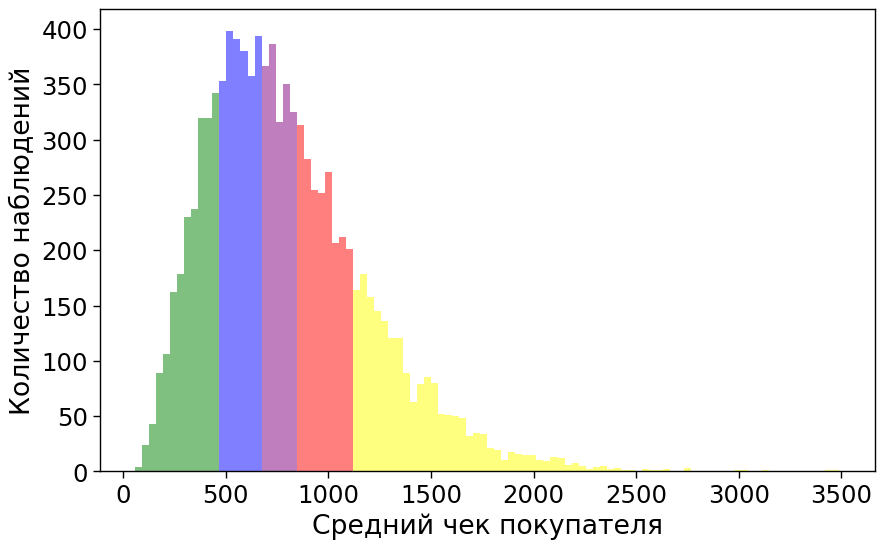

In [112]:
np.random.seed(100)

avg_order_value = gamma.rvs(4, size=10000) * 200                # TODO: создайте нужное распределение

df = pd.DataFrame(avg_order_value, columns = ['avg_order_value'])
df['grp_avg_order_value'] = pd.qcut(df['avg_order_value'], 5)   # TODO: поменяйте количество частей

#Интервалы бинов
np.unique(df['grp_avg_order_value'])

#Границы бинов
bins_bound = list(np.unique(df['grp_avg_order_value'].map(attrgetter('left'))))
bins_bound

fig, ax = plt.subplots()
N, bins, patches = plt.hist(avg_order_value, alpha = 0.5, bins = 100)

for c, p in zip(bins, patches):
    if c >= bins_bound[0] and c < bins_bound[1]:
        plt.setp(p, 'facecolor', 'green')
    elif c >=  bins_bound[1] and c < bins_bound[2] :
        plt.setp(p, 'facecolor', 'blue')
    elif c >=  bins_bound[2] and c < bins_bound[3] :
        plt.setp(p, 'facecolor', 'purple')  
    elif c >=  bins_bound[3] and c < bins_bound[4] :
        plt.setp(p, 'facecolor', 'red')  
    else:
        plt.setp(p, 'facecolor', 'yellow')
    
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_xlabel('Средний чек покупателя')
ax.set_ylabel('Количество наблюдений')
plt.show()

In [122]:
np.random.seed(100)

def stratified_samples(data, metric, strat_var, bins, n_obs, random_state = None):
    A_group = []
    B_group = []
    
    #количество наблюдений для обеих групп из каждого бина
    n = int(n_obs/len(bins)*2)
    for i in bins:
        #выборка наблюдений размером n
        data_sample = data[data[strat_var] == i].sample(n, random_state = random_state).reset_index(drop=True)
        
        #рандомное разделение выборки на 2 рандомные группы
        indices = np.random.permutation(data_sample.shape[0])
        A_idx, B_idx = indices[:int(n/2)], indices[int(n/2):]
        A_sample, B_sample =  data_sample.iloc[A_idx,0], data_sample.iloc[B_idx,0]
        
        #объединение наблюдений из текущего бина к наблюдениям из предыдущих бинов
        A_group = np.hstack([A_group, np.array(A_sample)])
        B_group = np.hstack([B_group, np.array(B_sample)])
        
    return A_group, B_group

def random_samples(data, metric, n_obs, random_state = None):
    #выборка наблюдений размером n
    data_sample = data.sample(n_obs*2, random_state = random_state).reset_index(drop=True)
    
    #рандомное разделение выборки на 2 рандомные группы
    indices = np.random.permutation(data_sample.shape[0])
    A_idx, B_idx = indices[:int(n_obs)], indices[int(n_obs):]
    A_group, B_group =  data_sample.iloc[A_idx,0], data_sample.iloc[B_idx,0]
    
    return A_group, B_group

In [114]:
np.random.seed(100)

bins = np.unique(df['grp_avg_order_value'])

alpha = 0.05
strat_pvalue_res = []
random_pvalue_res = []

#1000 экспериментов
for i in range(1000):
    #получаем выборки с помощью двух способов - стратификации и рандома
    # TODO: измените количество элементов в подвыборке
    A_strat, B_strat = stratified_samples(df, 'avg_order_value', 'grp_avg_order_value', bins, 1000, random_state = 3)
    A_random, B_random = random_samples(df, 'avg_order_value', 1000,  random_state = 3)
    
    #проведение t-test'а
    pvalue_strat = ttest_ind(A_strat, B_strat)[1]
    pvalue_random = ttest_ind(A_random, B_random)[1]
    
    #сохранение результатов t-test'а
    strat_pvalue_res.append(pvalue_strat < alpha)
    random_pvalue_res.append(pvalue_random < alpha)
    
print("Доля ошибок первого рода при сегментации", np.mean(strat_pvalue_res))
print("Доля ошибок первого рода при рандоме", np.mean(random_pvalue_res))

Доля ошибок первого рода при сегментации 0.0
Доля ошибок первого рода при рандоме 0.064


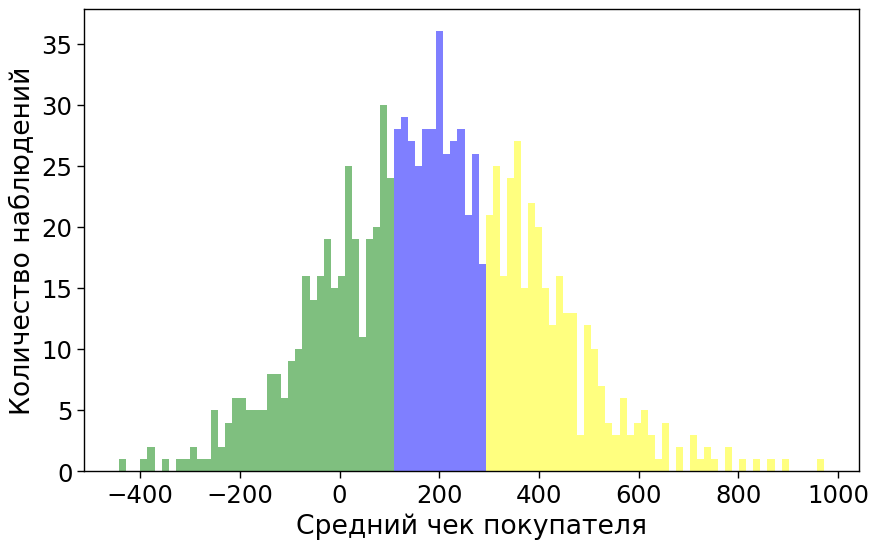

In [125]:
np.random.seed(100)

avg_order_value = np.random.normal(loc=1, scale=1, size=1000) * 200                # TODO: создайте нужное распределение


df = pd.DataFrame(avg_order_value, columns = ['avg_order_value'])
df['grp_avg_order_value'] = pd.qcut(df['avg_order_value'], 3)   # TODO: поменяйте количество частей



#Интервалы бинов
np.unique(df['grp_avg_order_value'])

#Границы бинов
bins_bound = list(np.unique(df['grp_avg_order_value'].map(attrgetter('left'))))
bins_bound


fig, ax = plt.subplots()
N, bins, patches = plt.hist(avg_order_value, alpha = 0.5, bins = 100)

for c, p in zip(bins, patches):
    if c >= bins_bound[0] and c < bins_bound[1]:
        plt.setp(p, 'facecolor', 'green')
    elif c >=  bins_bound[1] and c < bins_bound[2] :
        plt.setp(p, 'facecolor', 'blue')
    else:
        plt.setp(p, 'facecolor', 'yellow')
    
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_xlabel('Средний чек покупателя')
ax.set_ylabel('Количество наблюдений')
plt.show()

In [126]:
np.random.seed(100)

def stratified_samples(data, metric, strat_var, bins, n_obs, random_state = None):
    A_group = []
    B_group = []
    
    #количество наблюдений для обеих групп из каждого бина
    n = int(n_obs/len(bins)*2)
    for i in bins:
        #выборка наблюдений размером n
        data_sample = data[data[strat_var] == i].sample(n, random_state = random_state).reset_index(drop=True)
        
        #рандомное разделение выборки на 2 рандомные группы
        indices = np.random.permutation(data_sample.shape[0])
        A_idx, B_idx = indices[:int(n/2)], indices[int(n/2):]
        A_sample, B_sample =  data_sample.iloc[A_idx,0], data_sample.iloc[B_idx,0]
        
        #объединение наблюдений из текущего бина к наблюдениям из предыдущих бинов
        A_group = np.hstack([A_group, np.array(A_sample)])
        B_group = np.hstack([B_group, np.array(B_sample)])
        
    return A_group, B_group

def random_samples(data, metric, n_obs, random_state = None):
    #выборка наблюдений размером n
    data_sample = data.sample(n_obs*2, random_state = random_state).reset_index(drop=True)
    
    #рандомное разделение выборки на 2 рандомные группы
    indices = np.random.permutation(data_sample.shape[0])
    A_idx, B_idx = indices[:int(n_obs)], indices[int(n_obs):]
    A_group, B_group =  data_sample.iloc[A_idx,0], data_sample.iloc[B_idx,0]
    
    return A_group, B_group

In [127]:
np.random.seed(100)

bins = np.unique(df['grp_avg_order_value'])

alpha = 0.05
strat_pvalue_res = []
random_pvalue_res = []

#1000 экспериментов
for i in range(1000):
    #получаем выборки с помощью двух способов - стратификации и рандома
    # TODO: измените количество элементов в подвыборке
    A_strat, B_strat = stratified_samples(df, 'avg_order_value', 'grp_avg_order_value', bins, 100, random_state = 3)
    A_random, B_random = random_samples(df, 'avg_order_value', 100,  random_state = 3)
    
    #проведение t-test'а
    pvalue_strat = ttest_ind(A_strat, B_strat)[1]
    pvalue_random = ttest_ind(A_random, B_random)[1]
    
    #сохранение результатов t-test'а
    strat_pvalue_res.append(pvalue_strat < alpha)
    random_pvalue_res.append(pvalue_random < alpha)
    
print("Доля ошибок первого рода при сегментации", np.mean(strat_pvalue_res))
print("Доля ошибок первого рода при рандоме", np.mean(random_pvalue_res))

Доля ошибок первого рода при сегментации 0.0
Доля ошибок первого рода при рандоме 0.048


## Практическое задание 4 "CUPED/CUPAC"

1. Сгенерируйте фичу “количество звонков в месяц” за предшествующий период.
2. Замоделируйте ее распределением по следующему правилу: **arpu_prev / 10 + np.random.gamma(2, 4, 10000)**.
3. Каково отношение полученного стандартного отклонения к исходному после применения CUPED, если в качестве ковариаты использовать созданный признак “количество звонков в месяц”? Ответ округлите до десятых. 

In [128]:
np.random.seed(100)

#АРПУ за предыдущий месяц
arpu_prev = np.random.gamma(2, 4, 10000) * 20
#АРПУ за текущий месяц
arpu_now =  0.5*arpu_prev + np.random.gamma(2, 5, 10000)*5

# TODO: создайте новый признак здесь

#Длительность пребывания клинента в компании (кол-во месяцев)
lifetime_cnt_prev = np.round(0.05*arpu_prev+2 + np.random.gamma(2, 4, 10000))
lifetime_cnt_now = np.round(0.05*arpu_prev+2 + np.random.gamma(2, 4, 10000))+ 1
#Признак тарифа с абонентской платой
month_fee_flag_prev = np.sign(0.05*arpu_prev + np.random.normal(2, 6, 10000))
month_fee_flag_now = month_fee_flag_prev 
#Количество дней с активным трафиком в месяц
traffic_days_cnt_prev = np.round(0.03*arpu_prev+2 + np.random.gamma(1, 2, 10000))
traffic_days_cnt_prev = np.where(traffic_days_cnt_prev > 31, 31, traffic_days_cnt_prev)

traffic_days_cnt_now = np.round(0.7*traffic_days_cnt_prev + np.random.gamma(1, 2, 10000))
traffic_days_cnt_now = np.where(traffic_days_cnt_now> 31, 31, traffic_days_cnt_now)
#Признак попадания в тестовую группу
treat_flag = np.sign(np.random.normal(0, 0.5, 10000))
treat_flag = np.where(treat_flag == -1, 0, treat_flag)

#Объединяем данные в один датасет
df = pd.DataFrame({'lifetime_cnt_now': lifetime_cnt_now, 
                   'lifetime_cnt_prev': lifetime_cnt_prev, 
                   'month_fee_flag_now': month_fee_flag_now,
                   'month_fee_flag_prev': month_fee_flag_prev, 
                   'traffic_days_cnt_now':traffic_days_cnt_now, 
                   'traffic_days_cnt_prev':traffic_days_cnt_prev,
                   'arpu_prev': arpu_prev, 
                   'arpu_now':arpu_now,
                   # TODO: добавьте новый признак в датафрейм
                   'treat_flag': treat_flag})

In [129]:
def cuped(df, target, groups, covariate):

    X = df.copy()

    cov = X[[target, covariate]].cov().loc[target, covariate]
    var = X[covariate].var()
    theta = cov / var

    for group in X[groups].unique():
        X_subdf = X[X[groups] == group]
        group_y_cuped = X_subdf[target] - theta * (X_subdf[covariate] - X_subdf[covariate].mean())
        X.loc[X[groups] == group, target] = group_y_cuped

    return X

0.5


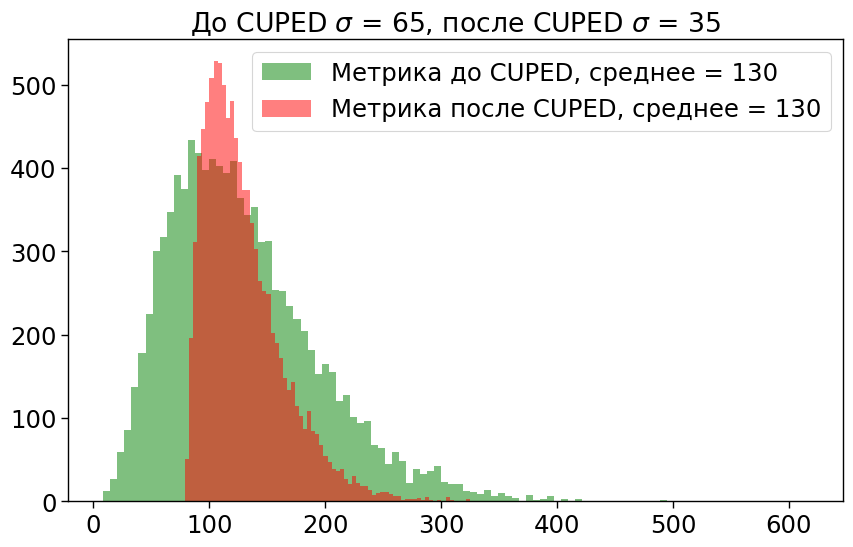

In [130]:
target = 'arpu_now'
covariate = 'arpu_prev' # TODO: измените ковариату на нужную
groups = 'treat_flag'

df_cuped_1 = cuped(df, target, groups, covariate)

std_bef_cuped =  round(df[target].std())
std_cuped = round(df_cuped_1[target].std())
mean_bef_cuped =  round(df[target].mean())
mean_cuped = round(df_cuped_1[target].mean())

print(np.round(std_cuped / std_bef_cuped, 1))

fig, ax = plt.subplots()
plt.hist(df[target], alpha = 0.5, label = f'Метрика до CUPED, среднее = {mean_bef_cuped}', color = 'green', bins = 100)
plt.hist(df_cuped_1[target], alpha = 0.5, label = f'Метрика после CUPED, среднее = {mean_cuped}', color = 'red', bins = 100)
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')

plt.show()

In [134]:
np.random.seed(100)

#АРПУ за предыдущий месяц
arpu_prev = np.random.gamma(2, 4, 10000) * 20
#АРПУ за текущий месяц
arpu_now =  0.5*arpu_prev + np.random.gamma(2, 5, 10000)*5

# TODO: создайте новый признак здесь
arpu_current = arpu_prev / 10 + np.random.gamma(2, 4, 10000)

#Длительность пребывания клинента в компании (кол-во месяцев)
lifetime_cnt_prev = np.round(0.05*arpu_prev+2 + np.random.gamma(2, 4, 10000))
lifetime_cnt_now = np.round(0.05*arpu_prev+2 + np.random.gamma(2, 4, 10000))+ 1
#Признак тарифа с абонентской платой
month_fee_flag_prev = np.sign(0.05*arpu_prev + np.random.normal(2, 6, 10000))
month_fee_flag_now = month_fee_flag_prev 
#Количество дней с активным трафиком в месяц
traffic_days_cnt_prev = np.round(0.03*arpu_prev+2 + np.random.gamma(1, 2, 10000))
traffic_days_cnt_prev = np.where(traffic_days_cnt_prev > 31, 31, traffic_days_cnt_prev)

traffic_days_cnt_now = np.round(0.7*traffic_days_cnt_prev + np.random.gamma(1, 2, 10000))
traffic_days_cnt_now = np.where(traffic_days_cnt_now> 31, 31, traffic_days_cnt_now)
#Признак попадания в тестовую группу
treat_flag = np.sign(np.random.normal(0, 0.5, 10000))
treat_flag = np.where(treat_flag == -1, 0, treat_flag)

#Объединяем данные в один датасет
df = pd.DataFrame({'lifetime_cnt_now': lifetime_cnt_now, 
                   'lifetime_cnt_prev': lifetime_cnt_prev, 
                   'month_fee_flag_now': month_fee_flag_now,
                   'month_fee_flag_prev': month_fee_flag_prev, 
                   'traffic_days_cnt_now':traffic_days_cnt_now, 
                   'traffic_days_cnt_prev':traffic_days_cnt_prev,
                   'arpu_prev': arpu_prev, 
                   'arpu_now':arpu_now,
                   # TODO: добавьте новый признак в датафрейм
                   'arpu_current':arpu_current,
                   'treat_flag': treat_flag})
df

,lifetime_cnt_now,lifetime_cnt_prev,month_fee_flag_now,month_fee_flag_prev,traffic_days_cnt_now,traffic_days_cnt_prev,arpu_prev,arpu_now,arpu_current,treat_flag
0,21.0,9.0,1.0,1.0,7.0,4.0,21.967748,38.434437,6.643219,0.0
1,15.0,12.0,1.0,1.0,5.0,7.0,171.949033,111.526257,21.035132,1.0
2,16.0,24.0,1.0,1.0,14.0,17.0,262.532331,199.040564,27.690146,0.0
3,25.0,16.0,1.0,1.0,12.0,8.0,193.804920,129.288087,26.487124,1.0
4,10.0,9.0,1.0,1.0,5.0,6.0,114.704235,119.829493,15.235854,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,12.0,18.0,1.0,1.0,6.0,6.0,92.726390,59.024902,11.769380,1.0
9996,21.0,22.0,1.0,1.0,8.0,9.0,234.098777,120.812987,42.224487,0.0
9997,31.0,25.0,-1.0,-1.0,11.0,6.0,103.365953,66.924525,16.375570,0.0
9998,25.0,10.0,1.0,1.0,7.0,8.0,130.961125,78.291120,18.759560,1.0


In [132]:
def cuped(df, target, groups, covariate):

    X = df.copy()

    cov = X[[target, covariate]].cov().loc[target, covariate]
    var = X[covariate].var()
    theta = cov / var

    for group in X[groups].unique():
        X_subdf = X[X[groups] == group]
        group_y_cuped = X_subdf[target] - theta * (X_subdf[covariate] - X_subdf[covariate].mean())
        X.loc[X[groups] == group, target] = group_y_cuped

    return X

0.7


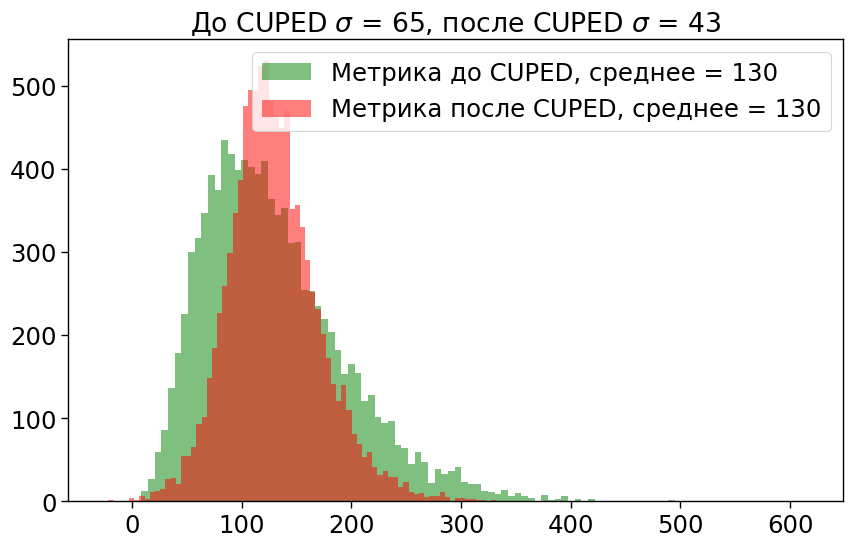

std_cuped/std_bef_cuped = 0.7


In [138]:
target = 'arpu_now'
covariate = 'arpu_current' # TODO: измените ковариату на нужную
groups = 'treat_flag'

df_cuped_1 = cuped(df, target, groups, covariate)

std_bef_cuped =  round(df[target].std())
std_cuped = round(df_cuped_1[target].std())
mean_bef_cuped =  round(df[target].mean())
mean_cuped = round(df_cuped_1[target].mean())

print(np.round(std_cuped / std_bef_cuped, 1))

fig, ax = plt.subplots()
plt.hist(df[target], alpha = 0.5, label = f'Метрика до CUPED, среднее = {mean_bef_cuped}', color = 'green', bins = 100)
plt.hist(df_cuped_1[target], alpha = 0.5, label = f'Метрика после CUPED, среднее = {mean_cuped}', color = 'red', bins = 100)
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()
ax.set_title(f'До CUPED $\\sigma$ = {std_bef_cuped}, после CUPED $\\sigma$ = {std_cuped}')

plt.show()

print(f'std_cuped/std_bef_cuped = {round(std_cuped/std_bef_cuped, 1)}')